# XGBoost Starter - LB 0.793
In this notebook we build and train an XGBoost model using @raddar Kaggle dataset from [here][1] with discussion [here][2]. Then we engineer features suggested by @huseyincot in his notebooks [here][3] and [here][4]. This XGB model achieves CV 0.792 LB 0.793! When training with XGB, we use a special XGB dataloader called `DeviceQuantileDMatrix` which uses a small GPU memory footprint. This allows us to engineer more additional columns and train with more rows of data. Our feature engineering is performed using [RAPIDS][5] on the GPU to create new features quickly.

[1]: https://www.kaggle.com/datasets/raddar/amex-data-integer-dtypes-parquet-format
[2]: https://www.kaggle.com/competitions/amex-default-prediction/discussion/328514
[3]: https://www.kaggle.com/code/huseyincot/amex-catboost-0-793
[4]: https://www.kaggle.com/code/huseyincot/amex-agg-data-how-it-created
[5]: https://rapids.ai/

# Load Libraries

In [1]:
# LOAD LIBRARIES
import pandas as pd, numpy as np # CPU libraries
import cupy, cudf # GPU libraries
import matplotlib.pyplot as plt, gc, os

from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder

print('RAPIDS version',cudf.__version__)

RAPIDS version 21.10.01


In [2]:
# VERSION NAME FOR SAVED MODEL FILES
VER = 1

# TRAIN RANDOM SEED
SEED = 42

# FILL NAN VALUE
NAN_VALUE = -127 # will fit in int8

# FOLDS PER MODEL
FOLDS = 5

In [3]:
def init_logger(log_file='train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()

# Process and Feature Engineer Train Data
We will load @raddar Kaggle dataset from [here][1] with discussion [here][2]. Then we will engineer features suggested by @huseyincot in his notebooks [here][3] and [here][4]. We will use [RAPIDS][5] and the GPU to create new features quickly.

[1]: https://www.kaggle.com/datasets/raddar/amex-data-integer-dtypes-parquet-format
[2]: https://www.kaggle.com/competitions/amex-default-prediction/discussion/328514
[3]: https://www.kaggle.com/code/huseyincot/amex-catboost-0-793
[4]: https://www.kaggle.com/code/huseyincot/amex-agg-data-how-it-created
[5]: https://rapids.ai/

In [4]:
def read_file(path = '', usecols = None):
    # LOAD DATAFRAME
    if usecols is not None: df = cudf.read_parquet(path, columns=usecols)
    else: df = cudf.read_parquet(path)
    # REDUCE DTYPE FOR CUSTOMER AND DATE
    df['customer_ID'] = df['customer_ID'].str[-16:].str.hex_to_int().astype('int64')
    #df.S_2 = cudf.to_datetime( df.S_2 )
    # SORT BY CUSTOMER AND DATE (so agg('last') works correctly)
    #df = df.sort_values(['customer_ID','S_2'])
    #df = df.reset_index(drop=True)
    # FILL NAN
    df = df.fillna(NAN_VALUE) 
    print('shape of data:', df.shape)
    
    return df

print('Reading train data...')
TRAIN_PATH = '../input/amex-team-mizo/train_feature_preprocessed.parquet'
train = read_file(path = TRAIN_PATH)

Reading train data...
shape of data: (458913, 1367)


In [5]:
train.head()

,customer_ID,P_2_mean,P_2_std,P_2_min,P_2_max,P_2_last,D_39_mean,D_39_std,D_39_min,D_39_max,...,D_136_last_mean_diff,D_137_last_mean_diff,D_138_last_mean_diff,D_139_last_mean_diff,D_140_last_mean_diff,D_141_last_mean_diff,D_142_last_mean_diff,D_143_last_mean_diff,D_144_last_mean_diff,D_145_last_mean_diff
0,-4532153018459703766,0.933824,0.024194,0.868580,0.960384,0.934745,0.230769,0.832050,0,3,...,0.0,0.0,0.0,0.0,0.0,0.0,-127.0,0.0,-0.002313,0.0
1,-6696652885210834715,0.899820,0.022119,0.861109,0.929122,0.880519,7.153846,6.743468,0,19,...,0.0,0.0,0.0,0.0,0.0,0.0,-127.0,0.0,-0.001049,0.0
2,7128959966677571777,0.878454,0.028911,0.797670,0.904482,0.880875,0.000000,0.000000,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,-127.0,0.0,-0.004280,0.0
3,6537921148391624412,0.598969,0.020107,0.567442,0.623392,0.621776,1.538462,3.017045,0,9,...,0.0,0.0,0.0,0.0,0.0,0.0,-127.0,0.0,0.000792,0.0
4,2065103583825424365,0.891679,0.042325,0.805045,0.940382,0.871900,0.000000,0.000000,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,-127.0,0.0,0.002564,0.0


In [6]:
def process_and_feature_engineer(df):
    # Transform float64 and float32 to float16
    num_cols = list(df.dtypes[(df.dtypes == 'float32') | (df.dtypes == 'float64')].index)
    for col in tqdm(num_cols):
        df[col] = df[col].astype(np.float16)
        #test[col] = test[col].astype(np.float16)
    #features = [col for col in df.columns if col not in ['customer_ID', 'target']]
    features = pd.read_pickle('../input/amex-fi/important_feature_30.pkl')
    print('shape after engineering', df.shape )
    
    return df, features

# Train XGB
We will train using `DeviceQuantileDMatrix`. This has a very small GPU memory footprint.

In [7]:
# LOAD XGB LIBRARY
from sklearn.model_selection import KFold
import xgboost as xgb
print('XGB Version',xgb.__version__)

# XGB MODEL PARAMETERS
xgb_parms = { 
    'booster':'dart',
    'max_depth':4, 
    'learning_rate':0.05, 
    'subsample':0.8,
    'colsample_bytree':0.6, 
    'eval_metric':'logloss',
    'objective':'binary:logistic',
    'tree_method':'gpu_hist',
    'predictor':'gpu_predictor',
    'random_state':SEED
}

XGB Version 1.6.1


In [8]:
# NEEDED WITH DeviceQuantileDMatrix BELOW
class IterLoadForDMatrix(xgb.core.DataIter):
    def __init__(self, df=None, features=None, target=None, batch_size=256*1024):
        self.features = features
        self.target = target
        self.df = df
        self.it = 0 # set iterator to 0
        self.batch_size = batch_size
        self.batches = int( np.ceil( len(df) / self.batch_size ) )
        super().__init__()

    def reset(self):
        '''Reset the iterator'''
        self.it = 0

    def next(self, input_data):
        '''Yield next batch of data.'''
        if self.it == self.batches:
            return 0 # Return 0 when there's no more batch.
        
        a = self.it * self.batch_size
        b = min( (self.it + 1) * self.batch_size, len(self.df) )
        dt = cudf.DataFrame(self.df.iloc[a:b])
        input_data(data=dt[self.features], label=dt[self.target]) #, weight=dt['weight'])
        self.it += 1
        return 1

In [9]:
# https://www.kaggle.com/kyakovlev
# https://www.kaggle.com/competitions/amex-default-prediction/discussion/327534
def amex_metric_mod(y_true, y_pred):

    labels     = np.transpose(np.array([y_true, y_pred]))
    labels     = labels[labels[:, 1].argsort()[::-1]]
    weights    = np.where(labels[:,0]==0, 20, 1)
    cut_vals   = labels[np.cumsum(weights) <= int(0.04 * np.sum(weights))]
    top_four   = np.sum(cut_vals[:,0]) / np.sum(labels[:,0])

    gini = [0,0]
    for i in [1,0]:
        labels         = np.transpose(np.array([y_true, y_pred]))
        labels         = labels[labels[:, i].argsort()[::-1]]
        weight         = np.where(labels[:,0]==0, 20, 1)
        weight_random  = np.cumsum(weight / np.sum(weight))
        total_pos      = np.sum(labels[:, 0] *  weight)
        cum_pos_found  = np.cumsum(labels[:, 0] * weight)
        lorentz        = cum_pos_found / total_pos
        gini[i]        = np.sum((lorentz - weight_random) * weight)

    return 0.5 * (gini[1]/gini[0] + top_four)

In [10]:
train, features = process_and_feature_engineer(train.to_pandas())

100%|██████████| 1080/1080 [07:09<00:00,  2.51it/s]

shape after engineering (458913, 1367)


In [11]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 458913 entries, 0 to 458912
Columns: 1367 entries, customer_ID to D_145_last_mean_diff
dtypes: float16(1080), int16(27), int32(22), int64(13), int8(225)
memory usage: 1.1 GB
None


In [12]:
importances = []
oof = []

TRAIN_SUBSAMPLE = 1.0
gc.collect()

skf = KFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
#train = train.sort_index().reset_index()
LOGGER.info(f'There are {len(features)} features!')
for fold,(train_idx, valid_idx) in enumerate(skf.split(
            train, train.target )):
    
    # TRAIN WITH SUBSAMPLE OF TRAIN FOLD DATA
    if TRAIN_SUBSAMPLE<1.0:
        np.random.seed(SEED)
        train_idx = np.random.choice(train_idx, 
                       int(len(train_idx)*TRAIN_SUBSAMPLE), replace=False)
        np.random.seed(None)
    LOGGER.info('#'*25)
    LOGGER.info(f'### Fold {fold+1}')
    LOGGER.info(f'### Train size {len(train_idx)} Valid size　{len(valid_idx)}')
    LOGGER.info(f'### Training with {int(TRAIN_SUBSAMPLE*100)}% fold data...')
    LOGGER.info('#'*25)

    # TRAIN, VALID, TEST FOR FOLD K
    Xy_train = IterLoadForDMatrix(train.loc[train_idx], features, 'target')
    X_valid = train.loc[valid_idx, features]
    y_valid = train.loc[valid_idx, 'target']
    
    dtrain = xgb.DeviceQuantileDMatrix(Xy_train, max_bin=256)
    dvalid = xgb.DMatrix(data=X_valid, label=y_valid)
    
    # TRAIN MODEL FOLD K
    model = xgb.train(xgb_parms, 
                dtrain=dtrain,
                evals=[(dtrain,'train'),(dvalid,'valid')],
                num_boost_round=9999,
                early_stopping_rounds=100,
                verbose_eval=100) 
    model.save_model(f'XGB_v{VER}_fold{fold}.xgb')
    
    # GET FEATURE IMPORTANCE FOR FOLD K
    dd = model.get_score(importance_type='weight')
    df = pd.DataFrame({'feature':dd.keys(),f'importance_{fold}':dd.values()})
    importances.append(df)
            
    # INFER OOF FOLD K
    oof_preds = model.predict(dvalid)
    acc = amex_metric_mod(y_valid.values, oof_preds)
    LOGGER.info(f"fold{fold+1} score: {acc}")
    
    # SAVE OOF
    df = train.loc[valid_idx, ['customer_ID','target'] ].copy()
    df['oof_pred'] = oof_preds
    oof.append( df )
    
    del dtrain, Xy_train, dd, df
    del X_valid, y_valid, dvalid, model
    _ = gc.collect()

oof = pd.concat(oof,axis=0,ignore_index=True).set_index('customer_ID')
acc = amex_metric_mod(oof.target.values, oof.oof_pred.values)
LOGGER.info(f"all folds score: {acc}")

There are 740 features!
#########################
### Fold 1
### Train size 367130 Valid size　91783
### Training with 100% fold data...
#########################


[0]	train-logloss:0.66201	valid-logloss:0.66201
[100]	train-logloss:0.23585	valid-logloss:0.23845
[200]	train-logloss:0.22171	valid-logloss:0.22674
[300]	train-logloss:0.21569	valid-logloss:0.22283
[400]	train-logloss:0.21189	valid-logloss:0.22108
[500]	train-logloss:0.20884	valid-logloss:0.22002
[600]	train-logloss:0.20619	valid-logloss:0.21918
[700]	train-logloss:0.20385	valid-logloss:0.21872
[800]	train-logloss:0.20173	valid-logloss:0.21830
[900]	train-logloss:0.19973	valid-logloss:0.21801
[1000]	train-logloss:0.19776	valid-logloss:0.21778
[1100]	train-logloss:0.19595	valid-logloss:0.21759
[1200]	train-logloss:0.19421	valid-logloss:0.21749
[1300]	train-logloss:0.19255	valid-logloss:0.21734
[1400]	train-logloss:0.19087	valid-logloss:0.21730
[1500]	train-logloss:0.18927	valid-logloss:0.21722
[1600]	train-logloss:0.18773	valid-logloss:0.21708
[1700]	train-logloss:0.18616	valid-logloss:0.21700
[1800]	train-logloss:0.18467	valid-logloss:0.21702
[1900]	train-logloss:0.18310	valid-logloss:

fold1 score: 0.7937502048496587
#########################
### Fold 2
### Train size 367130 Valid size　91783
### Training with 100% fold data...
#########################


[0]	train-logloss:0.66198	valid-logloss:0.66197
[100]	train-logloss:0.23589	valid-logloss:0.23830
[200]	train-logloss:0.22175	valid-logloss:0.22653
[300]	train-logloss:0.21568	valid-logloss:0.22260
[400]	train-logloss:0.21178	valid-logloss:0.22068
[500]	train-logloss:0.20878	valid-logloss:0.21965
[600]	train-logloss:0.20616	valid-logloss:0.21885
[700]	train-logloss:0.20385	valid-logloss:0.21828
[800]	train-logloss:0.20165	valid-logloss:0.21778
[900]	train-logloss:0.19965	valid-logloss:0.21745
[1000]	train-logloss:0.19775	valid-logloss:0.21710
[1100]	train-logloss:0.19602	valid-logloss:0.21689
[1200]	train-logloss:0.19428	valid-logloss:0.21670
[1300]	train-logloss:0.19255	valid-logloss:0.21662
[1400]	train-logloss:0.19086	valid-logloss:0.21656
[1500]	train-logloss:0.18929	valid-logloss:0.21647
[1600]	train-logloss:0.18770	valid-logloss:0.21640
[1700]	train-logloss:0.18618	valid-logloss:0.21638
[1800]	train-logloss:0.18467	valid-logloss:0.21639
[1826]	train-logloss:0.18425	valid-logloss:

fold2 score: 0.7955297986470808
#########################
### Fold 3
### Train size 367130 Valid size　91783
### Training with 100% fold data...
#########################


[0]	train-logloss:0.66205	valid-logloss:0.66196
[100]	train-logloss:0.23662	valid-logloss:0.23577
[200]	train-logloss:0.22244	valid-logloss:0.22385
[300]	train-logloss:0.21659	valid-logloss:0.22016
[400]	train-logloss:0.21267	valid-logloss:0.21830
[500]	train-logloss:0.20961	valid-logloss:0.21719
[600]	train-logloss:0.20695	valid-logloss:0.21644
[700]	train-logloss:0.20459	valid-logloss:0.21591
[800]	train-logloss:0.20249	valid-logloss:0.21546
[900]	train-logloss:0.20047	valid-logloss:0.21511
[1000]	train-logloss:0.19857	valid-logloss:0.21484
[1100]	train-logloss:0.19674	valid-logloss:0.21466
[1200]	train-logloss:0.19492	valid-logloss:0.21454
[1300]	train-logloss:0.19319	valid-logloss:0.21436
[1400]	train-logloss:0.19148	valid-logloss:0.21421
[1500]	train-logloss:0.18993	valid-logloss:0.21416
[1600]	train-logloss:0.18838	valid-logloss:0.21410
[1698]	train-logloss:0.18686	valid-logloss:0.21412


fold3 score: 0.7953325868816934
#########################
### Fold 4
### Train size 367131 Valid size　91782
### Training with 100% fold data...
#########################


[0]	train-logloss:0.66199	valid-logloss:0.66203
[100]	train-logloss:0.23604	valid-logloss:0.23904
[200]	train-logloss:0.22184	valid-logloss:0.22697
[300]	train-logloss:0.21580	valid-logloss:0.22298
[400]	train-logloss:0.21194	valid-logloss:0.22094
[500]	train-logloss:0.20900	valid-logloss:0.21981
[600]	train-logloss:0.20637	valid-logloss:0.21884
[700]	train-logloss:0.20408	valid-logloss:0.21825
[800]	train-logloss:0.20196	valid-logloss:0.21785
[900]	train-logloss:0.19999	valid-logloss:0.21748
[1000]	train-logloss:0.19807	valid-logloss:0.21723
[1100]	train-logloss:0.19631	valid-logloss:0.21703
[1200]	train-logloss:0.19457	valid-logloss:0.21688
[1300]	train-logloss:0.19288	valid-logloss:0.21675
[1400]	train-logloss:0.19122	valid-logloss:0.21664
[1500]	train-logloss:0.18962	valid-logloss:0.21649
[1600]	train-logloss:0.18804	valid-logloss:0.21636
[1700]	train-logloss:0.18648	valid-logloss:0.21628
[1800]	train-logloss:0.18499	valid-logloss:0.21627
[1900]	train-logloss:0.18347	valid-logloss:

fold4 score: 0.7918859100934627
#########################
### Fold 5
### Train size 367131 Valid size　91782
### Training with 100% fold data...
#########################


[0]	train-logloss:0.66195	valid-logloss:0.66214
[100]	train-logloss:0.23534	valid-logloss:0.24080
[200]	train-logloss:0.22123	valid-logloss:0.22899
[300]	train-logloss:0.21535	valid-logloss:0.22505
[400]	train-logloss:0.21148	valid-logloss:0.22299
[500]	train-logloss:0.20844	valid-logloss:0.22174
[600]	train-logloss:0.20585	valid-logloss:0.22098
[700]	train-logloss:0.20358	valid-logloss:0.22038
[800]	train-logloss:0.20145	valid-logloss:0.21986
[900]	train-logloss:0.19943	valid-logloss:0.21959
[1000]	train-logloss:0.19752	valid-logloss:0.21941
[1100]	train-logloss:0.19567	valid-logloss:0.21919
[1200]	train-logloss:0.19396	valid-logloss:0.21906
[1300]	train-logloss:0.19223	valid-logloss:0.21890
[1400]	train-logloss:0.19062	valid-logloss:0.21877
[1500]	train-logloss:0.18899	valid-logloss:0.21872
[1600]	train-logloss:0.18742	valid-logloss:0.21864
[1700]	train-logloss:0.18581	valid-logloss:0.21855
[1795]	train-logloss:0.18436	valid-logloss:0.21855


fold5 score: 0.7916351794951119
all folds score: 0.7937686229524561


In [13]:
# CLEAN RAM
del train
_ = gc.collect()

# Save OOF Preds

In [14]:
oof_xgb = pd.read_parquet(TRAIN_PATH, columns=['customer_ID']).drop_duplicates()
oof_xgb['customer_ID_hash'] = oof_xgb['customer_ID'].apply(lambda x: int(x[-16:],16) ).astype('int64')
oof_xgb = oof_xgb.set_index('customer_ID_hash')
oof_xgb = oof_xgb.merge(oof, left_index=True, right_index=True)
oof_xgb = oof_xgb.sort_index().reset_index(drop=True)
oof_xgb.to_csv(f'oof_xgb_v{VER}.csv',index=False)
oof_xgb.head()

,customer_ID,target,oof_pred
0,20eac26171c3d251c55fc78204e59fab1c15fc2bc96d0c...,1,0.651322
1,aea50fdf9b974ccec95fa177c3225a0f913483b457de6e...,0,0.000296
2,32cd2d41aef737b69089882754395925c96eaee1f4a859...,0,0.001616
3,8daa6d5dc2655a8a437531e6b8b96829113cdfe9bf6cae...,0,0.012508
4,0ceba351a3851202542feb49d7385bcef32f6037fc57c7...,1,0.861143


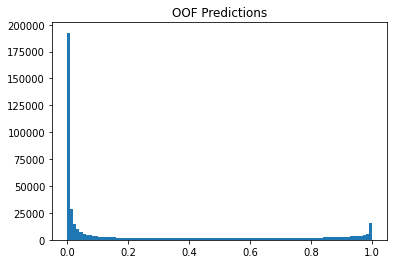

In [15]:
# PLOT OOF PREDICTIONS
plt.hist(oof_xgb.oof_pred.values, bins=100)
plt.title('OOF Predictions')
plt.show()

In [16]:
# CLEAR VRAM, RAM FOR INFERENCE BELOW
del oof_xgb, oof
_ = gc.collect()

# Feature Importance

In [17]:
import matplotlib.pyplot as plt

df = importances[0].copy()
for k in range(1,FOLDS): df = df.merge(importances[k], on='feature', how='left')
df['importance'] = df.iloc[:,1:].mean(axis=1)
df = df.sort_values('importance',ascending=False)
df.to_csv(f'xgb_feature_importance_v{VER}.csv',index=False)

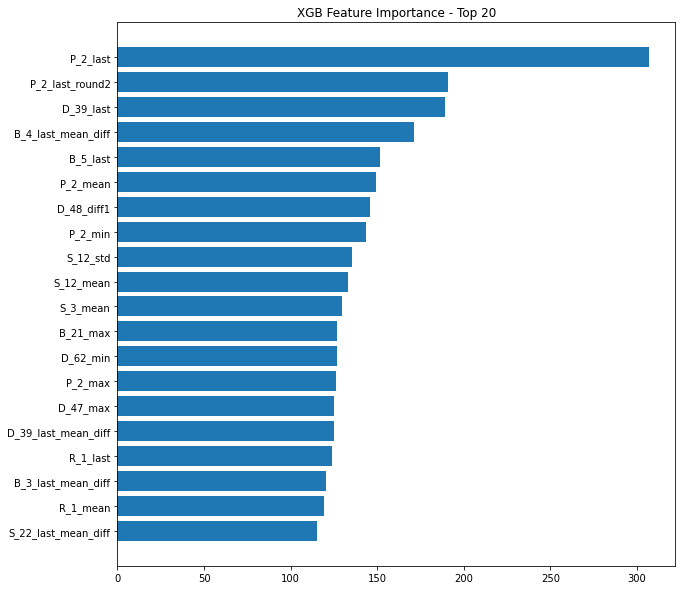

In [18]:
NUM_FEATURES = 20
plt.figure(figsize=(10,5*NUM_FEATURES//10))
plt.barh(np.arange(NUM_FEATURES,0,-1), df.importance.values[:NUM_FEATURES])
plt.yticks(np.arange(NUM_FEATURES,0,-1), df.feature.values[:NUM_FEATURES])
plt.title(f'XGB Feature Importance - Top {NUM_FEATURES}')
plt.show()

# Process and Feature Engineer Test Data
We will load @raddar Kaggle dataset from [here][1] with discussion [here][2]. Then we will engineer features suggested by @huseyincot in his notebooks [here][1] and [here][4]. We will use [RAPIDS][5] and the GPU to create new features quickly.

[1]: https://www.kaggle.com/datasets/raddar/amex-data-integer-dtypes-parquet-format
[2]: https://www.kaggle.com/competitions/amex-default-prediction/discussion/328514
[3]: https://www.kaggle.com/code/huseyincot/amex-catboost-0-793
[4]: https://www.kaggle.com/code/huseyincot/amex-agg-data-how-it-created
[5]: https://rapids.ai/

# CALCULATE SIZE OF EACH SEPARATE TEST PART
def get_rows(customers, test, NUM_PARTS = 4, verbose = ''):
    chunk = len(customers)//NUM_PARTS
    if verbose != '':
        print(f'We will process {verbose} data as {NUM_PARTS} separate parts.')
        print(f'There will be {chunk} customers in each part (except the last part).')
        print('Below are number of rows in each part:')
    rows = []

    for k in range(NUM_PARTS):
        if k==NUM_PARTS-1: cc = customers[k*chunk:]
        else: cc = customers[k*chunk:(k+1)*chunk]
        s = test.loc[test.customer_ID.isin(cc)].shape[0]
        rows.append(s)
    if verbose != '': print( rows )
    return rows,chunk

# COMPUTE SIZE OF 4 PARTS FOR TEST DATA
NUM_PARTS = 4
TEST_PATH = '../input/amex-team-mizo/test_feature_preprocessed.parquet'

print(f'Reading test data...')
test = read_file(path = TEST_PATH, usecols = ['customer_ID','S_2'])
customers = test[['customer_ID']].drop_duplicates().sort_index().values.flatten()
rows,num_cust = get_rows(customers, test[['customer_ID']], NUM_PARTS = NUM_PARTS, verbose = 'test')

test.shape

# Infer Test

# INFER TEST DATA IN PARTS
skip_rows = 0
skip_cust = 0
test_preds = []
    
for k in range(NUM_PARTS):
    
    # READ PART OF TEST DATA
    print(f'\nReading test data...')
    test = read_file(path = TEST_PATH)
    test = test.iloc[skip_rows:skip_rows+rows[k]]
    skip_rows += rows[k]
    print(f'=> Test part {k+1} has shape', test.shape )
    
    # PROCESS AND FEATURE ENGINEER PART OF TEST DATA
    test, features = process_and_feature_engineer(test.to_pandas())
    if k==NUM_PARTS-1:
        test = test[test['customer_ID'].isin(customers[skip_cust:].get())]
    else:
        test = test[test['customer_ID'].isin(customers[skip_cust:skip_cust+num_cust].get())]
    skip_cust += num_cust
    
    # TEST DATA FOR XGB
    X_test = test[features]
    dtest = xgb.DMatrix(data=X_test)
    test = test[['P_2_mean']] # reduce memory
    del X_test
    gc.collect()

    # INFER XGB MODELS ON TEST DATA/
    model = xgb.Booster()
    model.load_model(f'XGB_v{VER}_fold0.xgb')
    preds = model.predict(dtest)
    for f in range(1,FOLDS):
        model.load_model(f'XGB_v{VER}_fold{f}.xgb')
        preds += model.predict(dtest)
    preds /= FOLDS
    test_preds.append(preds)

    # CLEAN MEMORY
    del dtest, model
    _ = gc.collect()

# Create Submission CSV

# WRITE SUBMISSION FILE
test_preds = np.concatenate(test_preds)
test = cudf.DataFrame(index=customers,data={'prediction':test_preds})
sub = cudf.read_csv('../input/amex-default-prediction/sample_submission.csv')[['customer_ID']]
sub['customer_ID_hash'] = sub['customer_ID'].str[-16:].str.hex_to_int().astype('int64')
sub = sub.set_index('customer_ID_hash')
sub = sub.merge(test[['prediction']], left_index=True, right_index=True, how='left')
sub = sub.reset_index(drop=True)

# DISPLAY PREDICTIONS
sub.to_csv(f'submission_xgb_v{VER}.csv',index=False)
print('Submission file shape is', sub.shape )
sub.head()

# PLOT PREDICTIONS
plt.hist(sub.to_pandas().prediction, bins=100)
plt.title('Test Predictions')
plt.show()